In [1]:
!pip install tensorflow-addons
!pip install keras-flops

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import cv2
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import glob
from keras.models import Model
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout, Flatten, Dense
import tensorflow_addons as tfa
from keras_flops import get_flops

     |████████████████████████████████| 1.1 MB 30.6 MB/s 
     |████████████████████████████████| 462 kB 37.8 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

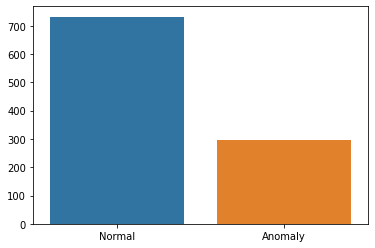

In [4]:
trainLabels = "/content/drive/MyDrive/diabeticRetinopathy/train/"
testLabels = "/content/drive/MyDrive/diabeticRetinopathy/test/"
valLabels = "/content/drive/MyDrive/diabeticRetinopathy/val/"

trainNormal = glob.glob(trainLabels+"normal/*.jpeg")
trainAnomaly = glob.glob(trainLabels+"anomaly/*.jpeg")
valNormal = glob.glob(valLabels+"normal/*.jpeg")
valAnomaly = glob.glob(valLabels+"anomaly/*.jpeg")
testNormal = glob.glob(testLabels+"normal/*.jpeg")
testAnomaly = glob.glob(testLabels+"anomaly/*.jpeg")

sns.barplot(x=["Normal","Anomaly"],y=[len(trainNormal),len(trainAnomaly)])

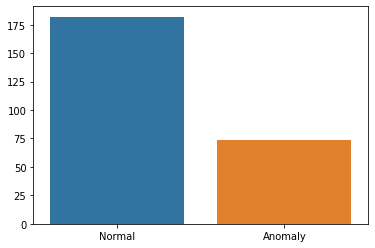

In [5]:
sns.barplot(x=["Normal","Anomaly"],y=[len(valNormal),len(valAnomaly)])

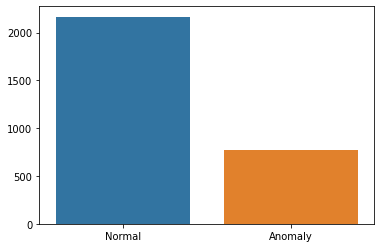

In [6]:
sns.barplot(x=["Normal","Anomaly"],y=[len(testNormal),len(testAnomaly)])

In [7]:
print('Anomaly images in training set = ', len(trainAnomaly))
print('Normal images in training set = ', len(trainNormal))
print('Anomaly images in validation set = ', len(valAnomaly))
print('Normal images in validation set = ', len(valNormal))
print('Anomaly images in testing set = ', len(testAnomaly))
print('Normal images in testing set = ', len(testNormal))

Anomaly images in training set =  297
Normal images in training set =  732
Anomaly images in validation set =  74
Normal images in validation set =  182
Anomaly images in testing set =  772
Normal images in testing set =  2166


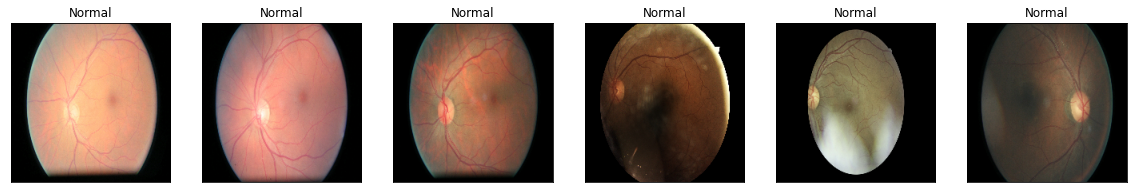

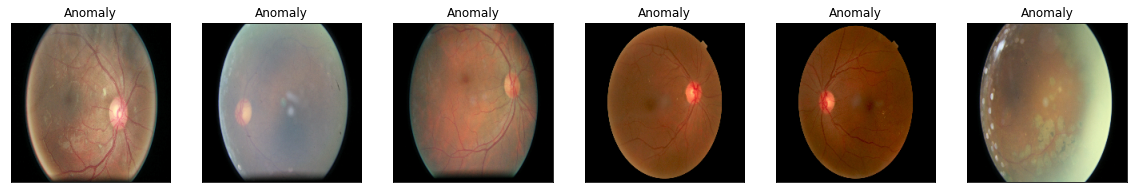

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,20), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(trainNormal[i])
    img = cv2.resize(img, (200,200))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title("Normal")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,20), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(trainAnomaly[i])
    img = cv2.resize(img, (200,200))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title("Anomaly")
plt.show()

In [9]:
training = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)
validation = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)
testing = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [10]:
training_dataset = training.flow_from_directory(trainLabels,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')
validation_dataset = validation.flow_from_directory(valLabels,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')
testing_dataset = testing.flow_from_directory(testLabels,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 1029 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 2938 images belonging to 2 classes.


In [11]:
testing_dataset.class_indices

{'anomaly': 0, 'normal': 1}

In [12]:
efficientNet = tf.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (224,224,3), classes = 2)
lastLayer = efficientNet.get_layer('top_activation')
X = lastLayer.output
X = tf.keras.layers.Flatten()(X)
# X = tf.keras.layers.Dropout(0.5)(X)

X = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model1 = tf.keras.Model(efficientNet.input, X)
model1.compile(loss = 'binary_crossentropy', 
             optimizer = tf.optimizers.Adam(learning_rate = 0.00002),
             metrics = ['accuracy'])
model1.summary()
flops = get_flops(model1, batch_size=32)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

In [28]:
lrReduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, cooldown = 0, verbose = 1, factor = 0.8, min_lr = 0.0000001)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 8, restore_best_weights = True)

In [ ]:
weights = {0: 2.,
           1: 1.}
history1 = model1.fit(training_dataset, validation_data = validation_dataset, epochs = 60, class_weight = weights, callbacks = [lrReduction, earlyStopping])

Epoch 1/60
33/33 [==============================] - 189s 5s/step - loss: 1.0730 - accuracy: 0.5578 - val_loss: 0.9681 - val_accuracy: 0.3555 - lr: 2.0000e-05
Epoch 2/60
33/33 [==============================] - 161s 5s/step - loss: 0.8520 - accuracy: 0.6492 - val_loss: 0.8105 - val_accuracy: 0.4805 - lr: 2.0000e-05
Epoch 3/60
33/33 [==============================] - 161s 5s/step - loss: 0.7260 - accuracy: 0.7026 - val_loss: 0.7423 - val_accuracy: 0.5508 - lr: 2.0000e-05
Epoch 4/60
33/33 [==============================] - 161s 5s/step - loss: 0.6279 - accuracy: 0.7784 - val_loss: 0.7510 - val_accuracy: 0.5625 - lr: 2.0000e-05
Epoch 5/60
33/33 [==============================] - 161s 5s/step - loss: 0.5966 - accuracy: 0.7949 - val_loss: 0.7062 - val_accuracy: 0.6094 - lr: 2.0000e-05
Epoch 6/60
33/33 [==============================] - 160s 5s/step - loss: 0.5123 - accuracy: 0.8601 - val_loss: 0.6969 - val_accuracy: 0.6406 - lr: 2.0000e-05
Epoch 7/60
33/33 [==============================] - 

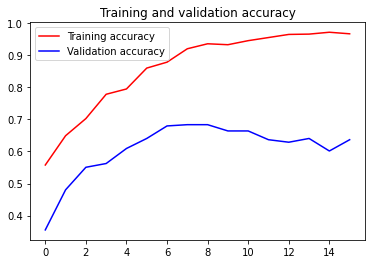

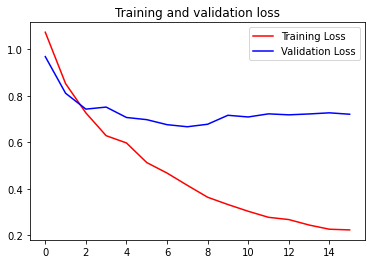

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model1.evaluate(testing_dataset)

92/92 [==============================] - 382s 4s/step - loss: 0.6696 - accuracy: 0.6787


[0.6695979833602905, 0.6786929965019226]

In [13]:
training2 = ImageDataGenerator(rescale = 1/255)
validation2 = ImageDataGenerator(rescale = 1/255)
testing2 = ImageDataGenerator(rescale = 1/255)

In [14]:
training_dataset2 = training2.flow_from_directory(trainLabels,
                                            target_size = (224,224), 
                                            batch_size = 16,
                                            class_mode = 'binary')
validation_dataset2 = validation2.flow_from_directory(valLabels,
                                            target_size = (224,224), 
                                            batch_size = 16,
                                            class_mode = 'binary')
testing_dataset2 = testing2.flow_from_directory(testLabels,
                                            target_size = (224,224), 
                                            batch_size = 16,
                                            class_mode = 'binary')

Found 1029 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 2938 images belonging to 2 classes.


In [16]:
model2 = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3),activation = 'relu', input_shape = (224,224,3)),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   tf.keras.layers.Dropout(0.3),
                                   #
                                   tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   tf.keras.layers.Dropout(0.3),
                                   #
                                   tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   tf.keras.layers.Dropout(0.3),
                                   #
                                   tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   tf.keras.layers.Dropout(0.3),
                                   #
                                   tf.keras.layers.Conv2D(256,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   tf.keras.layers.Dropout(0.3),
                                   #
                                   tf.keras.layers.Flatten(),
                                   ##
                                   tf.keras.layers.Dense(512,activation = 'relu'),
                                   ##
                                   tf.keras.layers.Dropout(0.5),
                                   ##                                     
                                   tf.keras.layers.Dense(1,activation = 'sigmoid'),
                                   ])
model2.compile(loss = 'binary_crossentropy', 
             optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])
model2.summary()
flops = get_flops(model2, batch_size=16)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_5 (Batc  (None, 222, 222, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 111, 111, 16)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_6 (Batc  (None, 109, 109, 32)    

In [ ]:
weights = {0: 2.,
           1: 1.}
history2 = model2.fit(training_dataset2, validation_data = validation_dataset2, epochs = 60, class_weight = weights, callbacks = [earlyStopping, lrReduction])

Epoch 1/60
65/65 [==============================] - 150s 2s/step - loss: 1.8093 - accuracy: 0.5423 - val_loss: 1.0435 - val_accuracy: 0.2891 - lr: 1.0000e-04
Epoch 2/60
65/65 [==============================] - 138s 2s/step - loss: 1.4492 - accuracy: 0.5384 - val_loss: 0.8521 - val_accuracy: 0.2891 - lr: 1.0000e-04
Epoch 3/60
65/65 [==============================] - 138s 2s/step - loss: 1.2401 - accuracy: 0.5821 - val_loss: 0.7717 - val_accuracy: 0.2969 - lr: 1.0000e-04
Epoch 4/60
65/65 [==============================] - 138s 2s/step - loss: 1.1510 - accuracy: 0.5277 - val_loss: 0.6578 - val_accuracy: 0.6172 - lr: 1.0000e-04
Epoch 5/60
65/65 [==============================] - 137s 2s/step - loss: 1.0076 - accuracy: 0.5588 - val_loss: 0.6667 - val_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 6/60
65/65 [==============================] - 136s 2s/step - loss: 0.9509 - accuracy: 0.6054 - val_loss: 0.6581 - val_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 7/60
65/65 [==============================] - 

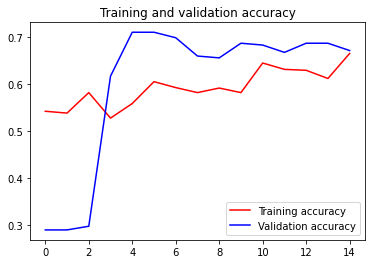

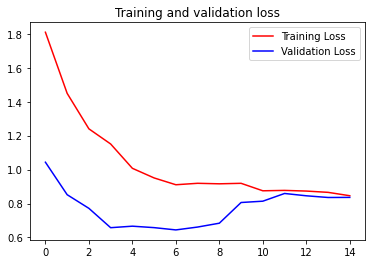

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model2.evaluate(testing_dataset2)

184/184 [==============================] - 328s 2s/step - loss: 0.7881 - accuracy: 0.7141


[0.788051426410675, 0.7140912413597107]

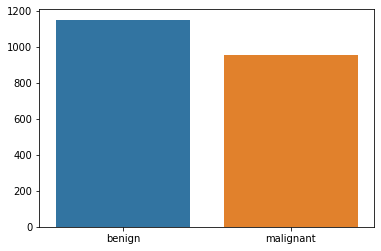

In [17]:
trainLabels2 = "/content/drive/MyDrive/skinCancer/train/"
testLabels2 = "/content/drive/MyDrive/skinCancer/test/"
valLabels2 = "/content/drive/MyDrive/skinCancer/val/"

trainNormal2 = glob.glob(trainLabels2+"benign/*.jpg")
trainAnomaly2 = glob.glob(trainLabels2+"malignant/*.jpg")
valNormal2 = glob.glob(valLabels2+"benign/*.jpg")
valAnomaly2 = glob.glob(valLabels2+"malignant/*.jpg")
testNormal2 = glob.glob(testLabels2+"benign/*.jpg")
testAnomaly2 = glob.glob(testLabels2+"malignant/*.jpg")

sns.barplot(x=["benign","malignant"],y=[len(trainNormal2),len(trainAnomaly2)])

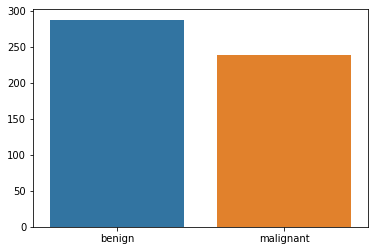

In [18]:
sns.barplot(x=["benign","malignant"],y=[len(valNormal2),len(valAnomaly2)])

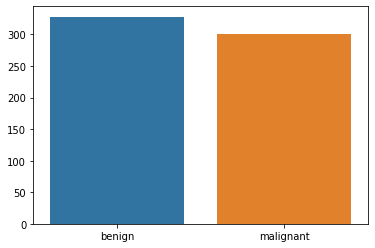

In [19]:
sns.barplot(x=["benign","malignant"],y=[len(testNormal2),len(testAnomaly2)])

In [20]:
print('Anomaly (malignant) images in training set = ', len(trainAnomaly2))
print('Normal (benign) images in training set = ', len(trainNormal2))
print('Anomaly (malignant) images in validation set = ', len(valAnomaly2))
print('Normal (benign) images in validation set = ', len(valNormal2))
print('Anomaly (malignant) images in testing set = ', len(testAnomaly2))
print('Normal (benign) images in testing set = ', len(testNormal2))

Anomaly (malignant) images in training set =  958
Normal (benign) images in training set =  1152
Anomaly (malignant) images in validation set =  239
Normal (benign) images in validation set =  288
Anomaly (malignant) images in testing set =  300
Normal (benign) images in testing set =  328


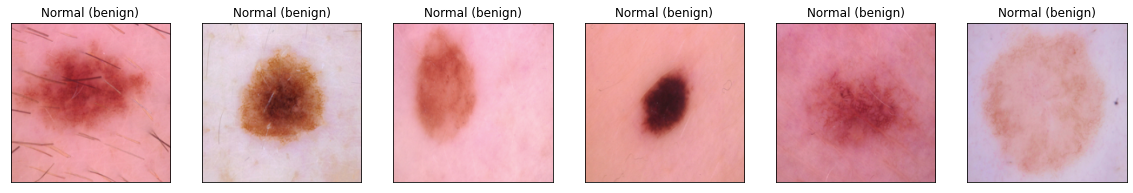

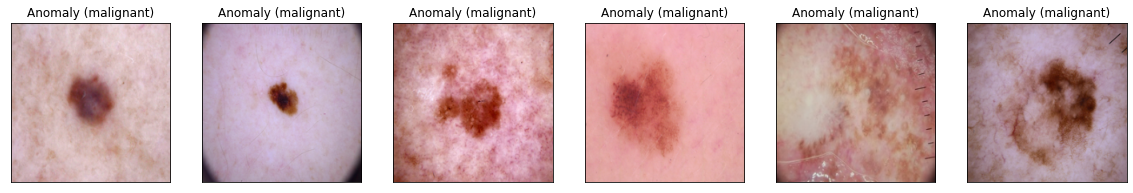

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,20), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(trainNormal2[i])
    img = cv2.resize(img, (200,200))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title("Normal (benign)")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,20), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(trainAnomaly2[i])
    img = cv2.resize(img, (200,200))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title("Anomaly (malignant)")
plt.show()

In [22]:
training_dataset3 = training.flow_from_directory(trainLabels2,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')
validation_dataset3 = validation.flow_from_directory(valLabels2,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')
testing_dataset3 = testing.flow_from_directory(testLabels2,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 628 images belonging to 2 classes.


In [23]:
testing_dataset3.class_indices


{'benign': 0, 'malignant': 1}

In [24]:
efficientNet = tf.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (224,224,3), classes = 2)
lastLayer = efficientNet.get_layer('top_activation')
X = lastLayer.output
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dropout(0.5)(X)

X = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model3= tf.keras.Model(efficientNet.input, X)
model3.compile(loss = 'binary_crossentropy', 
             optimizer = tf.optimizers.Adam(learning_rate = 0.000005), #0.00001 is good
             metrics = ['accuracy'])
model3.summary()
flops = get_flops(model3, batch_size=32)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
history3 = model3.fit(training_dataset3, validation_data = validation_dataset3, epochs = 60, callbacks = [lrReduction, earlyStopping])

Epoch 1/60
66/66 [==============================] - 32s 355ms/step - loss: 1.0138 - accuracy: 0.5005 - val_loss: 0.7520 - val_accuracy: 0.5218 - lr: 5.0000e-06
Epoch 2/60
66/66 [==============================] - 22s 335ms/step - loss: 0.8801 - accuracy: 0.5607 - val_loss: 0.6907 - val_accuracy: 0.5977 - lr: 5.0000e-06
Epoch 3/60
66/66 [==============================] - 22s 338ms/step - loss: 0.7355 - accuracy: 0.6114 - val_loss: 0.6909 - val_accuracy: 0.5882 - lr: 5.0000e-06
Epoch 4/60
66/66 [==============================] - 22s 334ms/step - loss: 0.6950 - accuracy: 0.6479 - val_loss: 0.6674 - val_accuracy: 0.6243 - lr: 5.0000e-06
Epoch 5/60
66/66 [==============================] - 22s 340ms/step - loss: 0.6218 - accuracy: 0.7071 - val_loss: 0.6226 - val_accuracy: 0.6565 - lr: 5.0000e-06
Epoch 6/60
66/66 [==============================] - 22s 339ms/step - loss: 0.5702 - accuracy: 0.7341 - val_loss: 0.5575 - val_accuracy: 0.7135 - lr: 5.0000e-06
Epoch 7/60
66/66 [======================

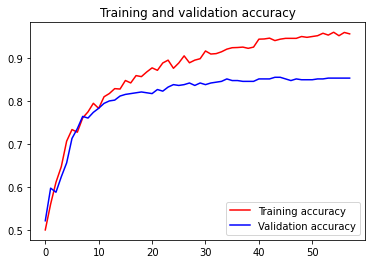

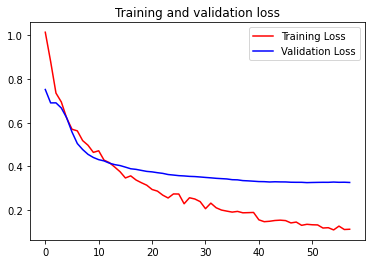

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model3.evaluate(testing_dataset3)

20/20 [==============================] - 3s 126ms/step - loss: 0.3044 - accuracy: 0.8854


[0.3044017255306244, 0.8853503465652466]

In [29]:
training_dataset4 = training2.flow_from_directory(trainLabels2,
                                            target_size = (224,224), 
                                            batch_size = 16,
                                            class_mode = 'binary')
validation_dataset4 = validation2.flow_from_directory(valLabels2,
                                            target_size = (224,224), 
                                            batch_size = 16,
                                            class_mode = 'binary')
testing_dataset4 = testing2.flow_from_directory(testLabels2,
                                            target_size = (224,224), 
                                            batch_size = 16,
                                            class_mode = 'binary')

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 628 images belonging to 2 classes.


In [30]:
model4 = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3),activation = 'relu', input_shape = (224,224,3)),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   tf.keras.layers.Dropout(0.3),

                                   #
                                   tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   tf.keras.layers.Dropout(0.3),
                                   #
                                   tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   tf.keras.layers.Dropout(0.3),
                                   #
                                   tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   tf.keras.layers.Dropout(0.3),
                                   #
                                   tf.keras.layers.Conv2D(256,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   tf.keras.layers.Dropout(0.3),
                                   #
                                   tf.keras.layers.Flatten(),
                                   ##
                                   tf.keras.layers.Dense(512,activation = 'relu'),
                                   ##
                                   tf.keras.layers.Dropout(0.5),
                                   tf.keras.layers.Dense(1,activation = 'sigmoid'),
                                   ])
model4.compile(loss = 'binary_crossentropy', 
             optimizer = tf.optimizers.Adam(learning_rate = 0.00001), #0.00001 is good
             metrics = ['accuracy'])
model4.summary()
flops = get_flops(model4, batch_size=16)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_20 (Bat  (None, 222, 222, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 111, 111, 16)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_21 (Bat  (None, 109, 109, 32)    

In [ ]:
history4 = model4.fit(training_dataset4, validation_data = validation_dataset4, epochs = 60, callbacks = [lrReduction, earlyStopping])

Epoch 1/60
66/66 [==============================] - 177s 160ms/step - loss: 1.1127 - accuracy: 0.5839 - val_loss: 0.7649 - val_accuracy: 0.5465 - lr: 1.0000e-05
Epoch 2/60
66/66 [==============================] - 10s 153ms/step - loss: 0.9047 - accuracy: 0.6664 - val_loss: 0.8804 - val_accuracy: 0.5465 - lr: 1.0000e-05
Epoch 3/60
66/66 [==============================] - 10s 153ms/step - loss: 0.8580 - accuracy: 0.6896 - val_loss: 0.9285 - val_accuracy: 0.5465 - lr: 1.0000e-05
Epoch 4/60
66/66 [==============================] - ETA: 0s - loss: 0.7848 - accuracy: 0.7019
Epoch 4: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
66/66 [==============================] - 10s 155ms/step - loss: 0.7848 - accuracy: 0.7019 - val_loss: 0.8046 - val_accuracy: 0.5465 - lr: 1.0000e-05
Epoch 5/60
66/66 [==============================] - 10s 158ms/step - loss: 0.7481 - accuracy: 0.7213 - val_loss: 0.7836 - val_accuracy: 0.5503 - lr: 8.0000e-06
Epoch 6/60
66/66 [======================

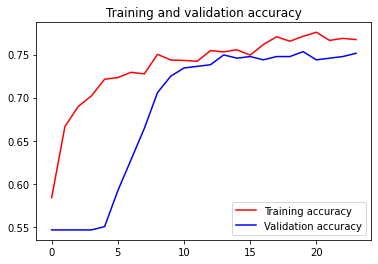

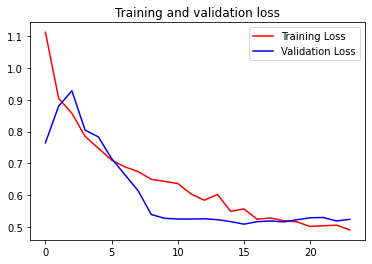

In [ ]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model4.evaluate(testing_dataset4)

20/20 [==============================] - 3s 135ms/step - loss: 0.4430 - accuracy: 0.7755


[0.4429803490638733, 0.7754777073860168]